# Feature Analysis for Answer Classification

This notebook analyzes features that distinguish between the 4 answer classes:
- **Dodging**: Avoids the question
- **Explicit**: Directly answers
- **General**: Broad, non-specific answer
- **Partial/half-answer**: Answers only part of the question

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import spacy
import re
from collections import Counter

nlp = spacy.load("en_core_web_sm")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

df = pd.read_parquet("../dataset/train_with_features.parquet")
FOUR_CLASSES = ["Dodging", "Explicit", "General", "Partial/half-answer"]
df = df[df["label"].isin(FOUR_CLASSES)].reset_index(drop=True)
print(f"Dataset: {len(df)} samples")
print(df["label"].value_counts())

Dataset: 2223 samples
label
Explicit               1052
Dodging                 706
General                 386
Partial/half-answer      79
Name: count, dtype: int64


## Feature Extraction

Extract comprehensive features for analysis.

In [14]:
def extract_all_features(row):
    q = str(row["question"])
    a = str(row["interview_answer"])
    q_lower = q.lower().strip()
    a_lower = a.lower().strip()
    q_words = q_lower.split()
    a_words = a_lower.split()
    
    features = {}
    
    # === SEMANTIC SIMILARITY ===
    q_emb = sbert.encode(q)
    a_emb = sbert.encode(a[:1500])
    features["semantic_sim"] = 1 - cosine(q_emb, a_emb)
    
    # First sentence similarity
    first_sent = a.split('.')[0] if '.' in a else a[:150]
    first_emb = sbert.encode(first_sent)
    features["first_sent_sim"] = 1 - cosine(q_emb, first_emb)
    
    # Last sentence similarity (topic drift?)
    sentences = [s.strip() for s in a.split('.') if s.strip()]
    if len(sentences) > 1:
        last_emb = sbert.encode(sentences[-1])
        features["last_sent_sim"] = 1 - cosine(q_emb, last_emb)
        features["topic_drift"] = features["first_sent_sim"] - features["last_sent_sim"]
    else:
        features["last_sent_sim"] = features["first_sent_sim"]
        features["topic_drift"] = 0
    
    # === LENGTH FEATURES ===
    features["q_len_words"] = len(q_words)
    features["a_len_words"] = len(a_words)
    features["a_q_ratio"] = len(a_words) / max(len(q_words), 1)
    
    # === QUESTION TYPE ===
    yes_no_starters = ["do ", "does ", "did ", "is ", "are ", "was ", "were ", "will ", "would ", "could ", "should ", "can ", "has ", "have ", "had "]
    features["is_yes_no_q"] = int(any(q_lower.startswith(s) for s in yes_no_starters))
    features["is_wh_q"] = int(any(q_lower.startswith(w) for w in ["what", "who", "where", "when", "why", "how", "which"]))
    features["q_has_multiple_questions"] = int(q.count("?") > 1)
    features["q_has_and"] = int(" and " in q_lower)
    features["q_is_complex"] = int(len(q_words) > 20 or features["q_has_and"] or features["q_has_multiple_questions"])
    
    # === ANSWER START PATTERNS ===
    direct_yes = {"yes", "yeah", "yep", "absolutely", "definitely", "certainly", "correct", "exactly", "right", "sure"}
    direct_no = {"no", "nope", "nah", "never", "not"}
    first_word = a_words[0] if a_words else ""
    first_3 = a_words[:3] if len(a_words) >= 3 else a_words
    
    features["starts_yes"] = int(first_word in direct_yes or any(w in direct_yes for w in first_3))
    features["starts_no"] = int(first_word in direct_no)
    features["starts_direct"] = int(features["starts_yes"] or features["starts_no"])
    features["starts_well"] = int(first_word == "well" or a_lower.startswith("well,"))
    features["starts_look"] = int(first_word == "look" or a_lower.startswith("look,"))
    features["starts_i"] = int(first_word == "i")
    features["starts_we"] = int(first_word == "we")
    features["starts_so"] = int(first_word == "so")
    features["starts_thank"] = int(a_lower.startswith("thank") or a_lower.startswith("thanks"))
    
    # === DEFLECTION/EVASION PATTERNS ===
    pivot_phrases = ["let me", "the fact is", "the truth is", "what matters", "the important thing", 
                     "the real question", "at the end of the day", "look,", "well, look", "first of all"]
    features["has_pivot"] = int(any(p in a_lower for p in pivot_phrases))
    features["pivot_count"] = sum(1 for p in pivot_phrases if p in a_lower)
    
    thanks_phrases = ["thank you", "thanks for", "great question", "good question", "appreciate"]
    features["has_thanks"] = int(any(t in a_lower for t in thanks_phrases))
    
    # Counter-question
    features["has_question_in_answer"] = int("?" in a)
    features["question_count_in_answer"] = a.count("?")
    features["ends_with_question"] = int(a.strip().endswith("?"))
    
    # === HEDGING/UNCERTAINTY ===
    hedges = ["maybe", "perhaps", "possibly", "might", "could", "seem", "appear", "somewhat", 
              "probably", "likely", "i think", "i believe", "i guess", "sort of", "kind of"]
    features["hedge_count"] = sum(1 for h in hedges if h in a_lower)
    features["hedge_ratio"] = features["hedge_count"] / max(len(a_words), 1) * 100
    
    # === SPECIFICITY ===
    features["num_count"] = len(re.findall(r'\d+', a))
    features["has_numbers"] = int(features["num_count"] > 0)
    features["percent_count"] = len(re.findall(r'\d+%', a))
    features["dollar_count"] = len(re.findall(r'\$[\d,]+', a))
    
    # Named entities (specific mentions)
    a_doc = nlp(a[:2000])
    q_doc = nlp(q[:500])
    a_entities = {ent.text.lower() for ent in a_doc.ents}
    q_entities = {ent.text.lower() for ent in q_doc.ents}
    features["a_entity_count"] = len(a_entities)
    features["q_entity_count"] = len(q_entities)
    features["entity_overlap"] = len(q_entities & a_entities) / max(len(q_entities), 1) if q_entities else 0
    features["entity_overlap_count"] = len(q_entities & a_entities)
    features["new_entities"] = len(a_entities - q_entities)
    
    # === LEXICAL OVERLAP ===
    q_content = {t.lemma_ for t in q_doc if not t.is_stop and not t.is_punct and t.is_alpha}
    a_content = {t.lemma_ for t in a_doc if not t.is_stop and not t.is_punct and t.is_alpha}
    features["lexical_overlap"] = len(q_content & a_content) / max(len(q_content), 1) if q_content else 0
    features["lexical_overlap_count"] = len(q_content & a_content)
    
    # === PRONOUN PATTERNS ===
    features["i_count"] = sum(1 for w in a_words if w == "i")
    features["we_count"] = sum(1 for w in a_words if w == "we")
    features["you_count"] = sum(1 for w in a_words if w == "you")
    features["they_count"] = sum(1 for w in a_words if w == "they")
    
    # === VAGUE vs SPECIFIC language ===
    vague_words = ["something", "things", "stuff", "everything", "anything", "people", "everyone", 
                   "somebody", "someone", "somewhere", "somehow", "whatever", "whenever"]
    features["vague_count"] = sum(1 for v in vague_words if v in a_words)
    features["vague_ratio"] = features["vague_count"] / max(len(a_words), 1) * 100
    
    # === COMBINATION FEATURES ===
    features["yes_no_q_direct_a"] = int(features["is_yes_no_q"] and features["starts_direct"])
    features["yes_no_q_no_direct"] = int(features["is_yes_no_q"] and not features["starts_direct"])
    features["wh_q_short_a"] = int(features["is_wh_q"] and len(a_words) < 30)
    
    return features

In [15]:
# Extract features for all samples (takes a few minutes)
print("Extracting features...")
all_features = []
for idx, row in df.iterrows():
    if idx % 200 == 0:
        print(f"  {idx}/{len(df)}")
    all_features.append(extract_all_features(row))

feature_df = pd.DataFrame(all_features)
feature_df["label"] = df["label"]
print(f"\nExtracted {len(feature_df.columns)-1} features")

Extracting features...
  0/2223
  200/2223
  400/2223
  600/2223
  800/2223
  1000/2223
  1200/2223
  1400/2223
  1600/2223
  1800/2223
  2000/2223
  2200/2223

Extracted 49 features


## Feature Analysis by Class

In [16]:
def analyze_feature(feature_name, feature_df):
    print(f"\n{'='*50}")
    print(f"FEATURE: {feature_name}")
    print(f"{'='*50}")
    
    for label in FOUR_CLASSES:
        subset = feature_df[feature_df["label"] == label][feature_name]
        print(f"{label:20s}: mean={subset.mean():.3f}, std={subset.std():.3f}, median={subset.median():.3f}")
    
    dodging = feature_df[feature_df["label"] == "Dodging"][feature_name]
    explicit = feature_df[feature_df["label"] == "Explicit"][feature_name]
    diff = abs(dodging.mean() - explicit.mean())
    print(f"\nDodging vs Explicit diff: {diff:.3f}")

key_features = [
    "semantic_sim", "first_sent_sim", "last_sent_sim", "topic_drift",
    "starts_direct", "starts_yes", "starts_no", "starts_well", "starts_look", "starts_thank",
    "has_pivot", "has_thanks", "has_question_in_answer", "ends_with_question",
    "hedge_count", "hedge_ratio", "vague_count", "vague_ratio",
    "entity_overlap", "lexical_overlap", "new_entities",
    "num_count", "has_numbers",
    "yes_no_q_direct_a", "yes_no_q_no_direct",
    "q_is_complex", "q_has_multiple_questions"
]

for feat in key_features:
    analyze_feature(feat, feature_df)


FEATURE: semantic_sim
Dodging             : mean=0.254, std=0.174, median=0.224
Explicit            : mean=0.373, std=0.173, median=0.382
General             : mean=0.354, std=0.179, median=0.356
Partial/half-answer : mean=0.379, std=0.175, median=0.374

Dodging vs Explicit diff: 0.119

FEATURE: first_sent_sim
Dodging             : mean=0.178, std=0.155, median=0.142
Explicit            : mean=0.260, std=0.195, median=0.210
General             : mean=0.233, std=0.178, median=0.191
Partial/half-answer : mean=0.234, std=0.184, median=0.182

Dodging vs Explicit diff: 0.082

FEATURE: last_sent_sim
Dodging             : mean=0.127, std=0.133, median=0.099
Explicit            : mean=0.149, std=0.145, median=0.117
General             : mean=0.135, std=0.129, median=0.108
Partial/half-answer : mean=0.123, std=0.148, median=0.085

Dodging vs Explicit diff: 0.022

FEATURE: topic_drift
Dodging             : mean=0.051, std=0.163, median=0.011
Explicit            : mean=0.111, std=0.216, median=0

## Feature Ranking by Discriminative Power

In [17]:
print("\n" + "="*60)
print("FEATURE RANKING BY DISCRIMINATIVE POWER")
print("="*60)

feature_scores = []
for col in feature_df.columns:
    if col == "label":
        continue
    
    dodging_mean = feature_df[feature_df["label"] == "Dodging"][col].mean()
    explicit_mean = feature_df[feature_df["label"] == "Explicit"][col].mean()
    general_mean = feature_df[feature_df["label"] == "General"][col].mean()
    partial_mean = feature_df[feature_df["label"] == "Partial/half-answer"][col].mean()
    
    overall_std = feature_df[col].std()
    if overall_std > 0:
        score_de = abs(dodging_mean - explicit_mean) / overall_std
        score_gp = abs(general_mean - partial_mean) / overall_std
    else:
        score_de = 0
        score_gp = 0
    
    feature_scores.append({
        "feature": col,
        "dodging": dodging_mean,
        "explicit": explicit_mean,
        "general": general_mean,
        "partial": partial_mean,
        "score_dodge_vs_explicit": score_de,
        "score_general_vs_partial": score_gp
    })

score_df = pd.DataFrame(feature_scores)

print("\n*** Top 20 features for DODGING vs EXPLICIT ***")
print(score_df.sort_values("score_dodge_vs_explicit", ascending=False).head(20)[["feature", "dodging", "explicit", "score_dodge_vs_explicit"]].to_string(index=False))

print("\n*** Top 20 features for GENERAL vs PARTIAL ***")
print(score_df.sort_values("score_general_vs_partial", ascending=False).head(20)[["feature", "general", "partial", "score_general_vs_partial"]].to_string(index=False))


FEATURE RANKING BY DISCRIMINATIVE POWER

*** Top 20 features for DODGING vs EXPLICIT ***
              feature  dodging  explicit  score_dodge_vs_explicit
         semantic_sim 0.253918  0.372600                 0.650468
      lexical_overlap 0.150033  0.312052                 0.609136
lexical_overlap_count 0.927762  1.720532                 0.464890
       first_sent_sim 0.177703  0.259793                 0.448273
         wh_q_short_a 0.089235  0.017110                 0.369817
          topic_drift 0.050837  0.110875                 0.295542
 entity_overlap_count 0.179887  0.310837                 0.232465
       entity_overlap 0.118720  0.184144                 0.194870
        starts_direct 0.004249  0.026616                 0.174790
        last_sent_sim 0.126866  0.148917                 0.158826
       a_entity_count 5.732295  6.508555                 0.148996
          starts_well 0.252125  0.195817                 0.132894
         new_entities 5.552408  6.197719            

## Visualizations

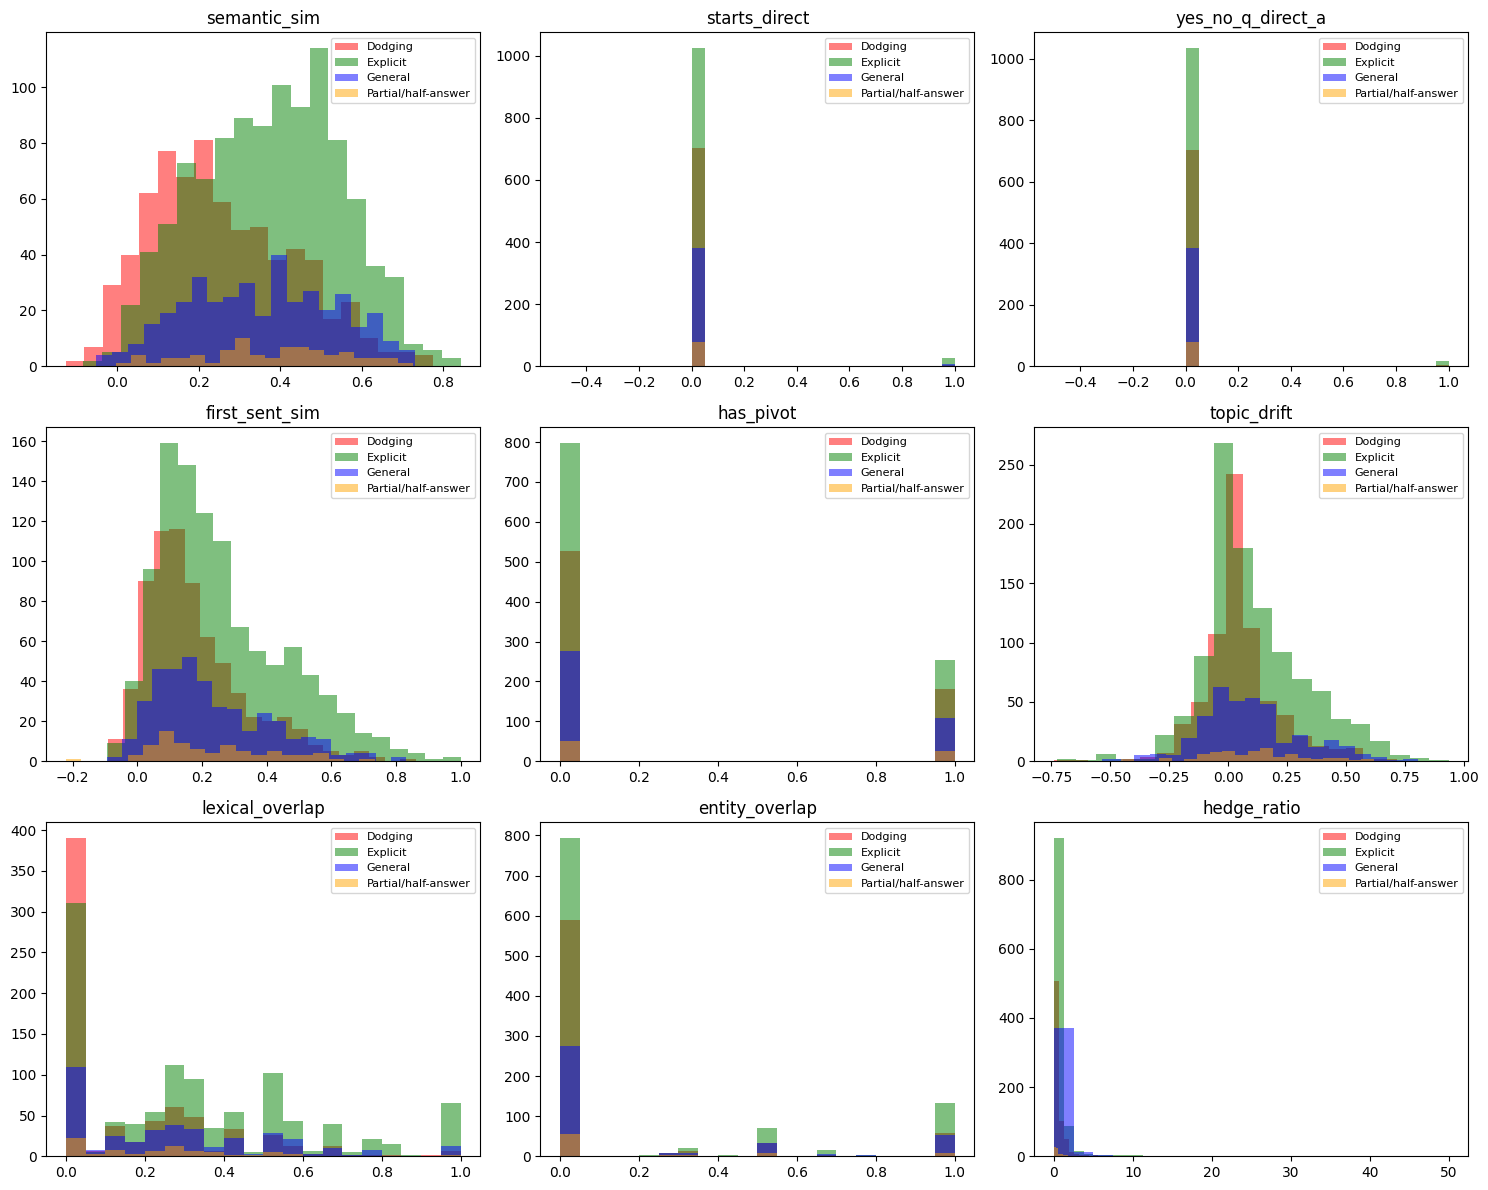

In [18]:
# Top features distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

top_features = ["semantic_sim", "starts_direct", "yes_no_q_direct_a", 
                "first_sent_sim", "has_pivot", "topic_drift",
                "lexical_overlap", "entity_overlap", "hedge_ratio"]

colors = {"Dodging": "red", "Explicit": "green", "General": "blue", "Partial/half-answer": "orange"}

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    for label in FOUR_CLASSES:
        data = feature_df[feature_df["label"] == label][feat]
        ax.hist(data, bins=20, alpha=0.5, label=label, color=colors[label])
    ax.set_title(feat, fontsize=12)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig("feature_distributions.png", dpi=150)
plt.show()

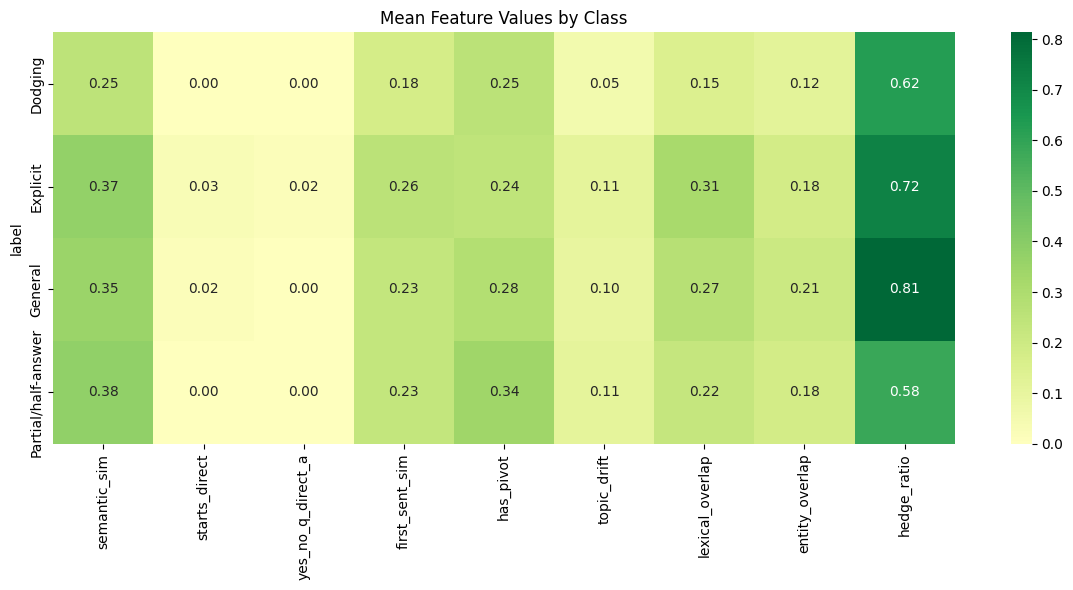

In [19]:
# Heatmap of mean feature values by class
mean_by_class = feature_df.groupby("label")[top_features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(mean_by_class, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Mean Feature Values by Class")
plt.tight_layout()
plt.savefig("feature_heatmap.png", dpi=150)
plt.show()

## Boolean Feature Comparison

In [20]:
print("\n" + "="*60)
print("BOOLEAN FEATURE PERCENTAGES BY CLASS")
print("="*60)

bool_features = ["starts_direct", "starts_yes", "starts_no", "starts_well", 
                 "starts_look", "starts_thank", "has_pivot", "has_thanks",
                 "has_question_in_answer", "ends_with_question", "has_numbers",
                 "yes_no_q_direct_a", "yes_no_q_no_direct", "q_is_complex"]

results = []
for feat in bool_features:
    row = {"feature": feat}
    for label in FOUR_CLASSES:
        pct = feature_df[feature_df["label"] == label][feat].mean() * 100
        row[label] = f"{pct:.1f}%"
    results.append(row)

bool_df = pd.DataFrame(results)
print(bool_df.to_string(index=False))


BOOLEAN FEATURE PERCENTAGES BY CLASS
               feature Dodging Explicit General Partial/half-answer
         starts_direct    0.4%     2.7%    1.6%                0.0%
            starts_yes    0.3%     1.5%    1.3%                0.0%
             starts_no    0.1%     1.1%    0.3%                0.0%
           starts_well   25.2%    19.6%   29.3%               30.4%
           starts_look    0.4%     0.4%    1.0%                2.5%
          starts_thank    1.6%     1.2%    1.3%                2.5%
             has_pivot   25.5%    24.2%   28.2%               34.2%
            has_thanks   15.4%    16.3%   18.7%               17.7%
has_question_in_answer   36.7%    35.3%   36.0%               40.5%
    ends_with_question    8.9%     6.5%    6.2%               10.1%
           has_numbers   36.0%    41.8%   40.4%               41.8%
     yes_no_q_direct_a    0.4%     1.6%    0.3%                0.0%
    yes_no_q_no_direct   38.2%    39.0%   36.5%               38.0%
          

## Additional Feature Analysis

Analyzing more linguistic features: modal verbs, negation, conditionals, temporal focus, politeness, etc.

In [21]:
def extract_more_features(row):
    q = str(row["question"])
    a = str(row["interview_answer"])
    q_lower = q.lower().strip()
    a_lower = a.lower().strip()
    q_words = q_lower.split()
    a_words = a_lower.split()
    
    features = {}
    
    # === MODAL VERBS (certainty vs uncertainty) ===
    certainty_modals = ["will", "must", "shall", "can"]
    uncertainty_modals = ["would", "could", "might", "may", "should"]
    features["certainty_modal_count"] = sum(1 for m in certainty_modals if m in a_words)
    features["uncertainty_modal_count"] = sum(1 for m in uncertainty_modals if m in a_words)
    features["modal_ratio"] = features["certainty_modal_count"] / max(features["uncertainty_modal_count"], 1)
    
    # === NEGATION PATTERNS ===
    negations = ["not", "no", "never", "nothing", "nobody", "nowhere", "neither", "none", "don't", "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't", "shouldn't"]
    features["negation_count"] = sum(1 for n in negations if n in a_words)
    features["negation_ratio"] = features["negation_count"] / max(len(a_words), 1) * 100
    
    # === CONDITIONAL LANGUAGE ===
    conditionals = ["if ", "unless ", "whether ", "in case ", "provided ", "assuming "]
    features["has_conditional"] = int(any(c in a_lower for c in conditionals))
    features["conditional_count"] = sum(1 for c in conditionals if c in a_lower)
    
    # === TEMPORAL REFERENCES ===
    past_words = ["was", "were", "had", "did", "went", "said", "told", "happened", "yesterday", "last", "ago", "before", "previously"]
    present_words = ["is", "are", "am", "now", "today", "currently", "right now", "at the moment"]
    future_words = ["will", "going to", "shall", "tomorrow", "next", "future", "soon", "plan to", "expect to"]
    features["past_count"] = sum(1 for p in past_words if p in a_words)
    features["present_count"] = sum(1 for p in present_words if p in a_words)
    features["future_count"] = sum(1 for f in future_words if f in a_lower)
    features["is_past_focus"] = int(features["past_count"] > features["future_count"])
    features["is_future_focus"] = int(features["future_count"] > features["past_count"])
    
    # === POLITENESS/ACKNOWLEDGMENT ===
    polite_phrases = ["i understand", "i appreciate", "thank you", "thanks for", "good question", 
                      "great question", "that's a fair", "you're right", "absolutely right"]
    features["has_politeness"] = int(any(p in a_lower for p in polite_phrases))
    features["politeness_count"] = sum(1 for p in polite_phrases if p in a_lower)
    
    # === SELF-CORRECTION/HESITATION ===
    hesitation = ["i mean", "you know", "sort of", "kind of", "like,", "basically", "actually", "honestly", "frankly"]
    features["hesitation_count"] = sum(1 for h in hesitation if h in a_lower)
    features["has_hesitation"] = int(features["hesitation_count"] > 0)
    
    # === QUANTIFIERS (specific vs vague) ===
    specific_quant = len(re.findall(r'\b\d+\b', a))
    vague_quant = ["some", "many", "few", "several", "lots", "much", "various", "numerous", "a lot"]
    features["specific_quantity_count"] = specific_quant
    features["vague_quantity_count"] = sum(1 for v in vague_quant if v in a_words)
    features["quantity_specificity"] = specific_quant / max(features["vague_quantity_count"], 1)
    
    # === COMPARATIVE/CONTRAST LANGUAGE ===
    comparatives = ["but", "however", "although", "though", "whereas", "while", "on the other hand", 
                    "in contrast", "nevertheless", "nonetheless", "yet", "still"]
    features["contrast_count"] = sum(1 for c in comparatives if c in a_lower)
    features["has_contrast"] = int(features["contrast_count"] > 0)
    
    # === CAUSAL LANGUAGE ===
    causal = ["because", "since", "therefore", "thus", "hence", "as a result", "due to", "owing to", "reason"]
    features["causal_count"] = sum(1 for c in causal if c in a_lower)
    features["has_causal"] = int(features["causal_count"] > 0)
    
    # === FIRST SENTENCE ANALYSIS ===
    first_sentence = a.split('.')[0] if '.' in a else a[:100]
    q_doc = nlp(q_lower[:300])
    q_nouns = {t.lemma_ for t in q_doc if t.pos_ == "NOUN"}
    first_sent_lower = first_sentence.lower()
    features["first_sent_has_q_noun"] = int(any(n in first_sent_lower for n in q_nouns))
    
    # === ANSWER POSITION OF KEY INFO ===
    third = len(a_words) // 3 if len(a_words) > 3 else 1
    first_third = " ".join(a_words[:third])
    last_third = " ".join(a_words[2*third:])
    features["numbers_in_first_third"] = len(re.findall(r'\d+', first_third))
    features["numbers_in_last_third"] = len(re.findall(r'\d+', last_third))
    features["info_front_loaded"] = int(features["numbers_in_first_third"] > features["numbers_in_last_third"])
    
    # === SENTENCE STRUCTURE ===
    sentences = [s.strip() for s in a.split('.') if s.strip()]
    features["sentence_count"] = len(sentences)
    features["avg_sentence_length"] = len(a_words) / max(len(sentences), 1)
    features["short_sentences"] = sum(1 for s in sentences if len(s.split()) < 10)
    features["long_sentences"] = sum(1 for s in sentences if len(s.split()) > 30)
    features["short_sentence_ratio"] = features["short_sentences"] / max(len(sentences), 1)
    
    # === REPETITION ===
    word_freq = Counter(a_words)
    most_common = word_freq.most_common(5)
    content_words = [w for w, c in most_common if w not in {"the", "a", "an", "is", "are", "to", "and", "of", "in", "that", "it", "for", "i", "we", "you"}]
    features["high_repetition"] = int(any(word_freq[w] > 5 for w in content_words)) if content_words else 0
    
    # === COMMITMENT LANGUAGE ===
    commitment = ["promise", "commit", "guarantee", "ensure", "definitely", "certainly", "absolutely", "100%", "for sure"]
    features["commitment_count"] = sum(1 for c in commitment if c in a_lower)
    features["has_commitment"] = int(features["commitment_count"] > 0)
    
    # === DEFLECTION TO OTHERS ===
    deflection = ["ask ", "you should", "you could", "they will", "they can", "someone else", "other people", "experts say"]
    features["has_deflection"] = int(any(d in a_lower for d in deflection))
    
    # === GENERALIZATION LANGUAGE ===
    generalizations = ["always", "never", "everyone", "nobody", "all", "none", "every", "any"]
    features["generalization_count"] = sum(1 for g in generalizations if g in a_words)
    features["has_generalization"] = int(features["generalization_count"] > 0)
    
    # === MORE ANSWER STARTS ===
    features["starts_with_number"] = int(bool(re.match(r'^\d', a.strip())))
    features["starts_with_i_think"] = int(a_lower.startswith("i think"))
    features["starts_with_i_believe"] = int(a_lower.startswith("i believe"))
    features["starts_with_well_look"] = int(a_lower.startswith("well, look") or a_lower.startswith("well look"))
    features["starts_with_that"] = int(a_words[0] == "that" if a_words else False)
    features["starts_with_its"] = int(a_words[0] in ["it's", "its"] if a_words else False)
    
    # === EVASION SPECIFIC ===
    evasion_phrases = ["the real issue", "what's important", "let's be clear", "the bottom line", 
                       "at the end of the day", "the bigger picture", "moving forward"]
    features["evasion_phrase_count"] = sum(1 for e in evasion_phrases if e in a_lower)
    features["has_evasion_phrase"] = int(features["evasion_phrase_count"] > 0)
    
    # === DIRECT ADDRESS ===
    direct_address = ["you asked", "your question", "to answer your", "what you're asking"]
    features["has_direct_address"] = int(any(d in a_lower for d in direct_address))
    
    return features

In [22]:
# Extract more features
print("Extracting additional features...")
more_features = []
for idx, row in df.iterrows():
    if idx % 300 == 0:
        print(f"  {idx}/{len(df)}")
    more_features.append(extract_more_features(row))

more_feature_df = pd.DataFrame(more_features)
more_feature_df["label"] = df["label"]
print(f"\nExtracted {len(more_feature_df.columns)-1} additional features")

Extracting additional features...
  0/2223
  300/2223
  600/2223
  900/2223
  1200/2223
  1500/2223
  1800/2223
  2100/2223

Extracted 47 additional features


In [23]:
# Analyze new features
print("\n" + "="*60)
print("NEW FEATURE ANALYSIS")
print("="*60)

new_features_to_check = [
    "certainty_modal_count", "uncertainty_modal_count", "modal_ratio",
    "negation_count", "negation_ratio",
    "has_conditional", "conditional_count",
    "is_past_focus", "is_future_focus",
    "has_politeness", "hesitation_count",
    "specific_quantity_count", "vague_quantity_count", "quantity_specificity",
    "contrast_count", "causal_count",
    "first_sent_has_q_noun", "info_front_loaded",
    "short_sentence_ratio", "high_repetition",
    "has_commitment", "has_deflection", "has_generalization",
    "starts_with_i_think", "starts_with_well_look",
    "has_evasion_phrase", "has_direct_address"
]

for feat in new_features_to_check:
    if feat in more_feature_df.columns:
        print(f"\n{feat}:")
        for label in FOUR_CLASSES:
            val = more_feature_df[more_feature_df["label"] == label][feat].mean()
            print(f"  {label:20s}: {val:.3f}")


NEW FEATURE ANALYSIS

certainty_modal_count:
  Dodging             : 0.856
  Explicit            : 0.911
  General             : 1.119
  Partial/half-answer : 1.089

uncertainty_modal_count:
  Dodging             : 0.840
  Explicit            : 0.953
  General             : 1.166
  Partial/half-answer : 0.911

modal_ratio:
  Dodging             : 0.627
  Explicit            : 0.678
  General             : 0.785
  Partial/half-answer : 0.867

negation_count:
  Dodging             : 1.806
  Explicit            : 1.948
  General             : 2.197
  Partial/half-answer : 2.089

negation_ratio:
  Dodging             : 1.105
  Explicit            : 1.103
  General             : 0.808
  Partial/half-answer : 0.907

has_conditional:
  Dodging             : 0.452
  Explicit            : 0.513
  General             : 0.604
  Partial/half-answer : 0.557

conditional_count:
  Dodging             : 0.562
  Explicit            : 0.660
  General             : 0.790
  Partial/half-answer : 0.747

i

In [24]:
# Rank new features
print("\n" + "="*60)
print("NEW FEATURE RANKING")
print("="*60)

new_scores = []
for col in more_feature_df.columns:
    if col == "label":
        continue
    
    dodging = more_feature_df[more_feature_df["label"] == "Dodging"][col].mean()
    explicit = more_feature_df[more_feature_df["label"] == "Explicit"][col].mean()
    general = more_feature_df[more_feature_df["label"] == "General"][col].mean()
    partial = more_feature_df[more_feature_df["label"] == "Partial/half-answer"][col].mean()
    
    std = more_feature_df[col].std()
    if std > 0:
        score_de = abs(dodging - explicit) / std
        score_gp = abs(general - partial) / std
    else:
        score_de = 0
        score_gp = 0
    
    new_scores.append({
        "feature": col,
        "dodging": dodging,
        "explicit": explicit,
        "general": general,
        "partial": partial,
        "score_de": score_de,
        "score_gp": score_gp
    })

new_score_df = pd.DataFrame(new_scores)

print("\n*** NEW Top 15 for DODGING vs EXPLICIT ***")
print(new_score_df.sort_values("score_de", ascending=False).head(15)[["feature", "dodging", "explicit", "score_de"]].to_string(index=False))

print("\n*** NEW Top 15 for GENERAL vs PARTIAL ***")
print(new_score_df.sort_values("score_gp", ascending=False).head(15)[["feature", "general", "partial", "score_gp"]].to_string(index=False))


NEW FEATURE RANKING

*** NEW Top 15 for DODGING vs EXPLICIT ***
                feature  dodging  explicit  score_de
  first_sent_has_q_noun 0.089235  0.176806  0.246246
         has_hesitation 0.440510  0.537072  0.193314
           has_contrast 0.637394  0.719582  0.180403
       hesitation_count 0.689802  0.861217  0.169188
      conditional_count 0.562323  0.659696  0.133694
          present_count 1.488669  1.653042  0.130411
             has_causal 0.432011  0.494297  0.124599
        has_conditional 0.451841  0.513308  0.122935
           causal_count 0.630312  0.736692  0.122618
   quantity_specificity 0.749457  0.956892  0.120049
           future_count 1.117564  1.236692  0.105649
uncertainty_modal_count 0.839943  0.953422  0.103482
  starts_with_i_believe 0.002833  0.000000  0.094466
         contrast_count 1.092068  1.196768  0.094225
specific_quantity_count 1.033994  1.245247  0.091058

*** NEW Top 15 for GENERAL vs PARTIAL ***
                feature   general   partial 

In [25]:
# Combine all features and rank
combined_df = pd.concat([feature_df.drop(columns=["label"]), more_feature_df], axis=1)

print("\n" + "="*60)
print("COMBINED FEATURE RANKING (ALL FEATURES)")
print("="*60)

all_scores = []
for col in combined_df.columns:
    if col == "label":
        continue
    
    try:
        dodging = combined_df[combined_df["label"] == "Dodging"][col].mean()
        explicit = combined_df[combined_df["label"] == "Explicit"][col].mean()
        general = combined_df[combined_df["label"] == "General"][col].mean()
        partial = combined_df[combined_df["label"] == "Partial/half-answer"][col].mean()
        
        std = combined_df[col].std()
        if std > 0:
            score_de = abs(dodging - explicit) / std
            score_gp = abs(general - partial) / std
            total_score = score_de + score_gp
        else:
            score_de = score_gp = total_score = 0
        
        all_scores.append({
            "feature": col,
            "dodge": dodging,
            "explicit": explicit,
            "general": general,
            "partial": partial,
            "score_de": score_de,
            "score_gp": score_gp,
            "total": total_score
        })
    except:
        pass

all_score_df = pd.DataFrame(all_scores)

print("\n*** TOP 30 OVERALL FEATURES (by total discriminative power) ***")
print(all_score_df.sort_values("total", ascending=False).head(30)[["feature", "score_de", "score_gp", "total"]].to_string(index=False))


COMBINED FEATURE RANKING (ALL FEATURES)

*** TOP 30 OVERALL FEATURES (by total discriminative power) ***
                 feature  score_de  score_gp    total
q_has_multiple_questions  0.026861  1.231129 1.257990
         lexical_overlap  0.609136  0.185746 0.794882
            semantic_sim  0.650468  0.133958 0.784426
            q_is_complex  0.011036  0.727081 0.738117
             q_len_words  0.008748  0.689128 0.697876
               q_has_and  0.000366  0.688352 0.688718
   lexical_overlap_count  0.464890  0.166247 0.631137
          q_entity_count  0.005992  0.496050 0.502041
          first_sent_sim  0.448273  0.004521 0.452794
            wh_q_short_a  0.369817  0.063391 0.433208
   first_sent_has_q_noun  0.246246  0.181753 0.427999
                 is_wh_q  0.126230  0.248726 0.374956
             topic_drift  0.295542  0.064721 0.360263
 uncertainty_modal_count  0.103482  0.231999 0.335481
         short_sentences  0.087051  0.222844 0.309895
    entity_overlap_count  0.23

In [26]:
# Save combined features
combined_df.to_parquet("../dataset/all_features_analyzed.parquet", index=False)
print(f"Saved {len(combined_df.columns)} features to ../dataset/all_features_analyzed.parquet")

# Print final summary
print("\n" + "="*70)
print("FINAL SUMMARY: BEST FEATURES TO USE")
print("="*70)

top_30 = all_score_df.sort_values("total", ascending=False).head(30)["feature"].tolist()
print("\nTop 30 features to use in model:")
for i, feat in enumerate(top_30):
    print(f"  {i+1}. {feat}")

Saved 97 features to ../dataset/all_features_analyzed.parquet

FINAL SUMMARY: BEST FEATURES TO USE

Top 30 features to use in model:
  1. q_has_multiple_questions
  2. lexical_overlap
  3. semantic_sim
  4. q_is_complex
  5. q_len_words
  6. q_has_and
  7. lexical_overlap_count
  8. q_entity_count
  9. first_sent_sim
  10. wh_q_short_a
  11. first_sent_has_q_noun
  12. is_wh_q
  13. topic_drift
  14. uncertainty_modal_count
  15. short_sentences
  16. entity_overlap_count
  17. starts_with_well_look
  18. starts_direct
  19. has_hesitation
  20. entity_overlap
  21. has_contrast
  22. present_count
  23. starts_yes
  24. last_sent_sim
  25. specific_quantity_count
  26. commitment_count
  27. ends_with_question
  28. num_count
  29. has_conditional
  30. sentence_count


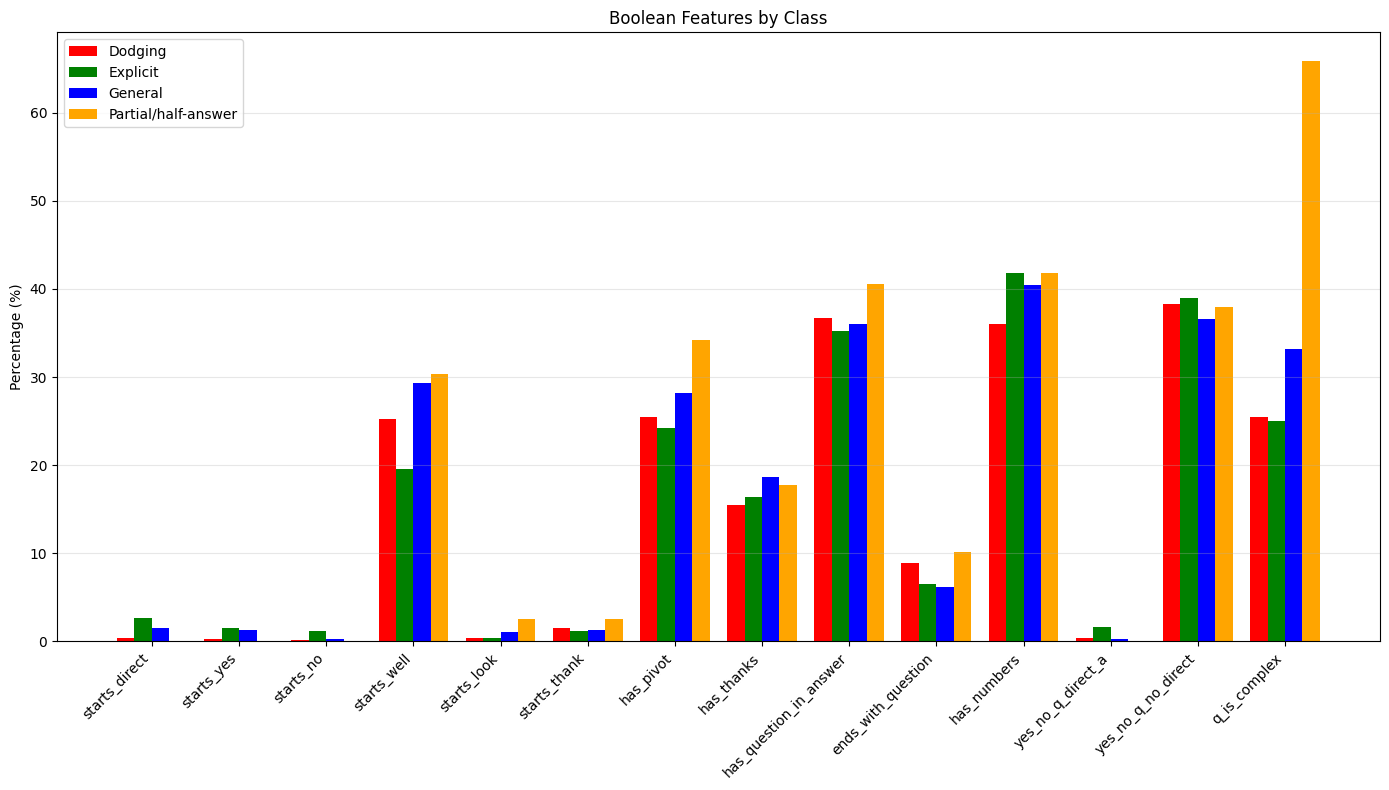

In [27]:
# Boolean features bar plot
fig, ax = plt.subplots(figsize=(14, 8))

bool_data = []
for feat in bool_features:
    for label in FOUR_CLASSES:
        pct = feature_df[feature_df["label"] == label][feat].mean() * 100
        bool_data.append({"feature": feat, "label": label, "percentage": pct})

bool_plot_df = pd.DataFrame(bool_data)

x = np.arange(len(bool_features))
width = 0.2

for i, label in enumerate(FOUR_CLASSES):
    data = bool_plot_df[bool_plot_df["label"] == label]["percentage"]
    ax.bar(x + i*width, data, width, label=label, color=colors[label])

ax.set_ylabel("Percentage (%)")
ax.set_title("Boolean Features by Class")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(bool_features, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("boolean_features.png", dpi=150)
plt.show()

## Correlation Analysis

In [28]:
# Feature correlation with class labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
feature_df["label_encoded"] = le.fit_transform(feature_df["label"])

correlations = []
for col in feature_df.columns:
    if col in ["label", "label_encoded"]:
        continue
    corr = feature_df[col].corr(feature_df["label_encoded"])
    correlations.append({"feature": col, "correlation": corr})

corr_df = pd.DataFrame(correlations).sort_values("correlation", key=abs, ascending=False)
print("\nTop 20 features by correlation with class label:")
print(corr_df.head(20).to_string(index=False))


Top 20 features by correlation with class label:
                 feature  correlation
            semantic_sim     0.221188
   lexical_overlap_count     0.199620
         lexical_overlap     0.159643
            wh_q_short_a    -0.138530
             q_len_words     0.129533
            q_is_complex     0.123099
          first_sent_sim     0.119361
             hedge_count     0.117215
    entity_overlap_count     0.116090
               q_has_and     0.115434
             vague_count     0.096998
q_has_multiple_questions     0.095623
             topic_drift     0.095085
          a_entity_count     0.092911
          entity_overlap     0.088359
          q_entity_count     0.085576
             a_len_words     0.085239
            new_entities     0.082717
                we_count     0.080196
                 i_count     0.065279


c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Summary: Best Discriminating Features

In [29]:
print("\n" + "="*70)
print("SUMMARY: BEST FEATURES FOR EACH CLASS DISTINCTION")
print("="*70)

print("\n*** DODGING vs EXPLICIT (main distinction) ***")
print("Features where Dodging > Explicit:")
for _, row in score_df.sort_values("score_dodge_vs_explicit", ascending=False).head(10).iterrows():
    if row["dodging"] > row["explicit"]:
        print(f"  - {row['feature']}: Dodging={row['dodging']:.3f}, Explicit={row['explicit']:.3f}")

print("\nFeatures where Explicit > Dodging:")
for _, row in score_df.sort_values("score_dodge_vs_explicit", ascending=False).head(10).iterrows():
    if row["explicit"] > row["dodging"]:
        print(f"  - {row['feature']}: Explicit={row['explicit']:.3f}, Dodging={row['dodging']:.3f}")

print("\n*** GENERAL vs PARTIAL ***")
for _, row in score_df.sort_values("score_general_vs_partial", ascending=False).head(10).iterrows():
    print(f"  - {row['feature']}: General={row['general']:.3f}, Partial={row['partial']:.3f}")


SUMMARY: BEST FEATURES FOR EACH CLASS DISTINCTION

*** DODGING vs EXPLICIT (main distinction) ***
Features where Dodging > Explicit:
  - wh_q_short_a: Dodging=0.089, Explicit=0.017

Features where Explicit > Dodging:
  - semantic_sim: Explicit=0.373, Dodging=0.254
  - lexical_overlap: Explicit=0.312, Dodging=0.150
  - lexical_overlap_count: Explicit=1.721, Dodging=0.928
  - first_sent_sim: Explicit=0.260, Dodging=0.178
  - topic_drift: Explicit=0.111, Dodging=0.051
  - entity_overlap_count: Explicit=0.311, Dodging=0.180
  - entity_overlap: Explicit=0.184, Dodging=0.119
  - starts_direct: Explicit=0.027, Dodging=0.004
  - last_sent_sim: Explicit=0.149, Dodging=0.127

*** GENERAL vs PARTIAL ***
  - q_has_multiple_questions: General=0.013, Partial=0.203
  - q_is_complex: General=0.332, Partial=0.658
  - q_len_words: General=15.293, Partial=21.342
  - q_has_and: General=0.225, Partial=0.494
  - q_entity_count: General=1.130, Partial=1.684
  - is_wh_q: General=0.326, Partial=0.215
  - star

In [30]:
# Save feature dataframe for later use
feature_df.to_parquet("../dataset/features_analyzed.parquet", index=False)
print("Features saved to ../dataset/features_analyzed.parquet")

Features saved to ../dataset/features_analyzed.parquet


In [33]:
print("="*70)
print("CHECKING DATASET")
print("="*70)

df_raw = pd.read_parquet("../dataset/train_with_features.parquet")

print(f"\nTotal rows: {len(df_raw)}")
print(f"\nAll columns: {df_raw.columns.tolist()}")

skip_cols = ["question", "interview_answer",
             "interview_question", "gpt3.5_summary", "title", "url"]

print("\n" + "="*70)
print("UNIQUE VALUES PER COLUMN")
print("="*70)

for col in df_raw.columns:
    if col in skip_cols:
        continue
    unique_vals = df_raw[col].nunique()
    print(f"\n{col}: {unique_vals} unique values")
    if unique_vals <= 20:
        print(f"  Values: {df_raw[col].value_counts().to_dict()}")

CHECKING DATASET

Total rows: 3448

All columns: ['question', 'interview_question', 'interview_answer', 'label', 'url', 'inaudible', 'multiple_questions', 'affirmative_questions', 'qa_similarity', 'topic_shift_score', 'first_sentence_similarity', 'answer_length_tokens', 'answer_length_chars', 'answer_to_question_len_ratio', 'num_sentences', 'hedge_score', 'filler_score', 'vague_word_count', 'modal_verb_count', 'num_numbers', 'num_named_entities', 'specificity_score', 'concreteness_score', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'afinn_score', 'emotion_confidence', 'pos_ratio_verbs', 'pos_ratio_nouns', 'pos_ratio_pronouns', 'num_clauses', 'starts_with_thanks', 'pivot_score', 'negation_count', 'deflection_score', 'ttr', 'entropy_score', 'keyword_overlap', 'entity_overlap']

UNIQUE VALUES PER COLUMN

label: 9 unique values
  Values: {'Explicit': 1052, 'Dodging': 706, 'Implicit': 488, 'General': 386, 'Deflection': 381, 'Declining to answer': 1